In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from deepjets import learning, models, preprocessing, utils

Using Theano backend.


//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
model = models.get_maxout(25**2)

In [22]:
learning.train_model(model, 'datasets/w_noshrink_mini_train.h5', 'models/w_noshrink_mini')

Training on 1600 samples, validating on 400 samples.
Datasets from datasets/w_noshrink_mini_train.h5.
Epoch 32/100: epochs w/o increase = 10, AUC = 17.9606098111                    
Patience tolerance reached.
Training complete. Best validation AUC = 18.1587300516


In [ ]:
n_images = -1
n_folds = 1
test_frac = 0.1
val_frac = 0.1
sig_file = 'images/w_images.h5'
bkd_file = 'images/qcd_images.h5'
dataset_name = 'datasets/test'
model_name = 'models/test'

In [ ]:
h5_files = utils.prepare_datasets(
    sig_file, bkd_file, dataset_name, n_sig=n_images, n_bkd=n_images, test_frac=test_frac,
    val_frac=val_frac, n_folds=n_folds, auxvars=['weights'], shuffle=True, shuffle_seed=1)

In [ ]:
learning.train_model(model, h5_files['train'], model_name)

In [ ]:
utils.plot_sig_bkd_dists(models.load_model('models/maxout_w_default'),
                         'datasets/w_test.h5')

In [ ]:
utils.plot_sig_bkd_dists(models.load_model('models/maxout_w_default_2'),
                         'datasets/w_test.h5')

In [ ]:
roc = learning.test_model(models.load_model('models/maxout_w_default'),
                          'datasets/w_test.h5', show_ROC_curve=False)

In [21]:
roc_2 = learning.test_model(models.load_model('models/maxout_w_default_2'),
                           'datasets/w_test.h5', show_ROC_curve=False)

Testing on 200000 samples.
Dataset from datasets/w_test.h5.
Score    = 0.446126715076
AUC      = 47.4265099969
Accuracy = 159766/200000 = 0.79883



In [ ]:
utils.plot_roc_curves([roc['ROC_curve'], roc_2['ROC_curve']],
                      ['MaxOut 162k images', 'MaxOut 450k images'])

In [ ]:
roc_mass = utils.auxvar_roc_curve('datasets/w_test.h5', 'mass')
roc_tau_21 = utils.auxvar_roc_curve('datasets/w_test.h5', 'tau_21', invert_score=True)

In [ ]:
utils.plot_roc_curves([roc_2['ROC_curve'], roc_tau_21, roc_mass],
                      ['MaxOut', r'$\tau_{21}$', 'mass'])

In [ ]:
import matplotlib.pyplot as plt
with h5py.File('datasets/w_test.h5', 'r') as h5file:
    Y_test = h5file['Y_test'][:]
    var = h5file['tau_21'][:]
var_s = var[Y_test[:, 0] == 1]
var_b = var[Y_test[:, 0] == 0]
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
bins = np.linspace(0, 1, 50)
ax.hist(var_s, bins=bins, histtype='stepfilled', normed=True, color='b', alpha=0.5,
        label='signal')
ax.hist(var_b, bins=bins, histtype='stepfilled', normed=True, color='r', alpha=0.5,
        label='background')
ax.set_xlabel("var", fontsize=16)
ax.set_ylabel("frequency", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=16, loc=2)
fig.show()

In [ ]:
with h5py.File('datasets/w_test.h5', 'r') as h5file:
    Y_test = h5file['Y_test'][:]
    var = h5file['mass'][:]
var_s = var[Y_test[:, 0] == 1]
var_b = var[Y_test[:, 0] == 0]
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
bins = np.linspace(0, 150, 50)
ax.hist(var_s, bins=bins, histtype='stepfilled', normed=True, color='b', alpha=0.5,
        label='signal')
ax.hist(var_b, bins=bins, histtype='stepfilled', normed=True, color='r', alpha=0.5,
        label='background')
ax.set_xlabel("var", fontsize=16)
ax.set_ylabel("frequency", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=16, loc=2)
fig.show()

In [ ]:
from sklearn.metrics import auc, roc_curve
from scipy.interpolate import interp1d
with h5py.File('datasets/w_test.h5', 'r') as h5file:
    Y_test = h5file['Y_test'][:]
    var = h5file['mass'][:]
var_s = var[Y_test[:, 0] == 1]
var_b = var[Y_test[:, 0] == 0]
var_b.sort()
n_bins = 1000
n_per_bin = len(var_b) / n_bins
bins = np.array([var_b[i] for i in xrange(0, len(var_b), n_per_bin)] + [var_b[-1]])
bins[0] = min(bins[0], var_s.min())
bins[-1] = max(bins[-1], var_s.max())
lklhd_rat, _ = np.histogram(var_s, bins)
score_s = lklhd_rat[np.searchsorted(bins[1:], var_s)]
score_b = lklhd_rat[np.searchsorted(bins[1:], var_b)]
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.hist(score_s, histtype='stepfilled', normed=True, color='b', alpha=0.5,
        label='signal')
ax.hist(score_b, histtype='stepfilled', normed=True, color='r', alpha=0.5,
        label='background')
ax.set_xlabel("var", fontsize=16)
ax.set_ylabel("frequency", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=16, loc=1)
fig.show()
fpr, tpr, _ = roc_curve(np.concatenate((np.ones(len(score_s)), np.zeros(len(score_b)))),
                        np.concatenate((score_s, score_b)))
res = 1./len(Y_test)
roc_mass = np.array(
    [[tp, 1./fp]
     for tp,fp in zip(tpr,fpr) if (0.2 <= tp <= 0.8 and fp > 0.)])
with h5py.File('datasets/w_test.h5', 'r') as h5file:
    Y_test = h5file['Y_test'][:]
    var = h5file['tau_21'][:]
var_s = var[Y_test[:, 0] == 1]
var_b = var[Y_test[:, 0] == 0]
var_b.sort()
n_bins = 1000
n_per_bin = len(var_b) / n_bins
bins = np.array([var_b[i] for i in xrange(0, len(var_b), n_per_bin)] + [var_b[-1]])
bins[0] = min(bins[0], var_s.min())
bins[-1] = max(bins[-1], var_s.max())
lklhd_rat, _ = np.histogram(var_s, bins)
score_s = lklhd_rat[np.searchsorted(bins[1:], var_s)]
score_b = lklhd_rat[np.searchsorted(bins[1:], var_b)]
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.hist(score_s, histtype='stepfilled', normed=True, color='b', alpha=0.5,
        label='signal')
ax.hist(score_b, histtype='stepfilled', normed=True, color='r', alpha=0.5,
        label='background')
ax.set_xlabel("var", fontsize=16)
ax.set_ylabel("frequency", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=16, loc=1)
fig.show()
fpr, tpr, _ = roc_curve(np.concatenate((np.ones(len(score_s)), np.zeros(len(score_b)))),
                        np.concatenate((score_s, score_b)))
res = 1./len(Y_test)
roc_tau_21 = np.array(
    [[tp, 1./fp]
     for tp,fp in zip(tpr,fpr) if (0.2 <= tp <= 0.8 and fp > 0.)])

In [19]:
roc_2_custom = learning.test_model(models.load_model('models/maxout_w_default_2'),
                                   'datasets/w_test.h5', show_ROC_curve=False,
                                   use_custom_roc_curve=True)

Testing on 200000 samples.
Dataset from datasets/w_test.h5.
Score    = 0.446126715076
AUC      = 44.4206813539
Accuracy = 159766/200000 = 0.79883



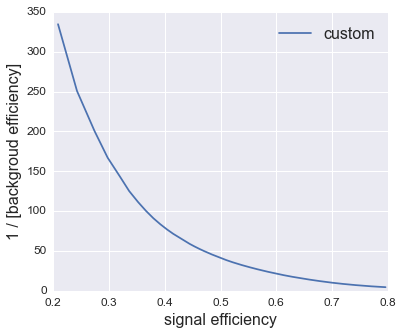

In [26]:
utils.plot_roc_curves([roc_2_custom['ROC_curve']],
                      ['custom'])